In [3]:
import galsim
import ngmix
import numpy as np
import piff
import glob
import proplot as pplt

In [6]:
def get_mag(flux):
    return 30 - 2.5*np.log10(flux)


21.747425010840047 22.059771852360797 0.31234684152074976


In [91]:
def _render_to_ngmix(*, gal, psf, rng, dim=53, scale=0.263, noise=1e-1, method="auto", meas_psf=None):
    if meas_psf is None:
        meas_psf = psf

    cen = (dim - 1) / 2

    dither = rng.uniform(-0.5, 0.5, size=2)
    obj = galsim.Convolve(gal, psf)

    obj_cen = cen + dither

    obj_jac = ngmix.DiagonalJacobian(
        scale=scale,
        row=obj_cen[0],
        col=obj_cen[1],
    )
    psf_jac = ngmix.DiagonalJacobian(
        scale=scale,
        row=cen,
        col=cen,
    )

    img = obj.drawImage(nx=dim, ny=dim, scale=scale, offset=dither, method=method).array
    wgt = np.ones_like(img) / noise**2

    psf_img = meas_psf.drawImage(nx=dim, ny=dim, scale=scale, method=method).array

    psf_obs = ngmix.Observation(
        image=psf_img,
        jacobian=psf_jac,
    )
    obj_obs = ngmix.Observation(
        image=img,
        weight=wgt,
        jacobian=obj_jac,
        psf=psf_obs,
    )
    return obj_obs

In [33]:
from ngmix.prepsfmom import PGaussMom


def _measure_color(obs_g, obs_i, fwhm=2.0):
    fitter = PGaussMom(fwhm=fwhm)

    res_i = fitter.go(obs_i)
    res_g = fitter.go(obs_g)

    assert res_i["flags"] == 0
    assert res_g["flags"] == 0

    mag_i_obs = get_mag(res_i['flux'])
    mag_g_obs = get_mag(res_g['flux'])

    return mag_g_obs - mag_i_obs, mag_i_obs, res_i["s2n"]

## Try Something Simple

In [54]:
import tqdm

factor = 1e3

flux_i = 2 * factor
flux_g = 1.5 * factor

noise = 1e1


num = 100

seeds = np.random.RandomState(seed=42).randint(1, 2**30, size=num)

data = np.zeros(num, dtype=[
    ('gmi_true', 'f8'),
    ('i_true', 'f8'),
    ('s2n_i_obs', 'f8'),
    ('gmi_obs', 'f8'),
    ('i_obs', 'f8'),
])

for i, seed in tqdm.tqdm(
    enumerate(seeds),
    ncols=80,
    total=num,
):

    mag_i = get_mag(flux_i)
    mag_g = get_mag(flux_g)

    gal = galsim.Sersic(n=2.5, half_light_radius=1.0)
    psf_g = galsim.Gaussian(fwhm=1.05)
    psf_i = galsim.Gaussian(fwhm=1.0)

    obs_i = _render_to_ngmix(gal=gal.withFlux(flux=flux_i), psf=psf_i, rng=np.random.RandomState(seed), noise=noise)
    obs_g = _render_to_ngmix(gal=gal.withFlux(flux=flux_g), psf=psf_g, rng=np.random.RandomState(seed), noise=noise)

    res = _measure_color(obs_g, obs_i)

    data["gmi_true"][i] = mag_g - mag_i
    data["i_true"][i] = mag_i
    data["s2n_i_obs"][i] = res[2]
    data["gmi_obs"][i] = res[0]
    data["i_obs"][i] = res[1]



  0%|                                                   | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 52.66it/s]


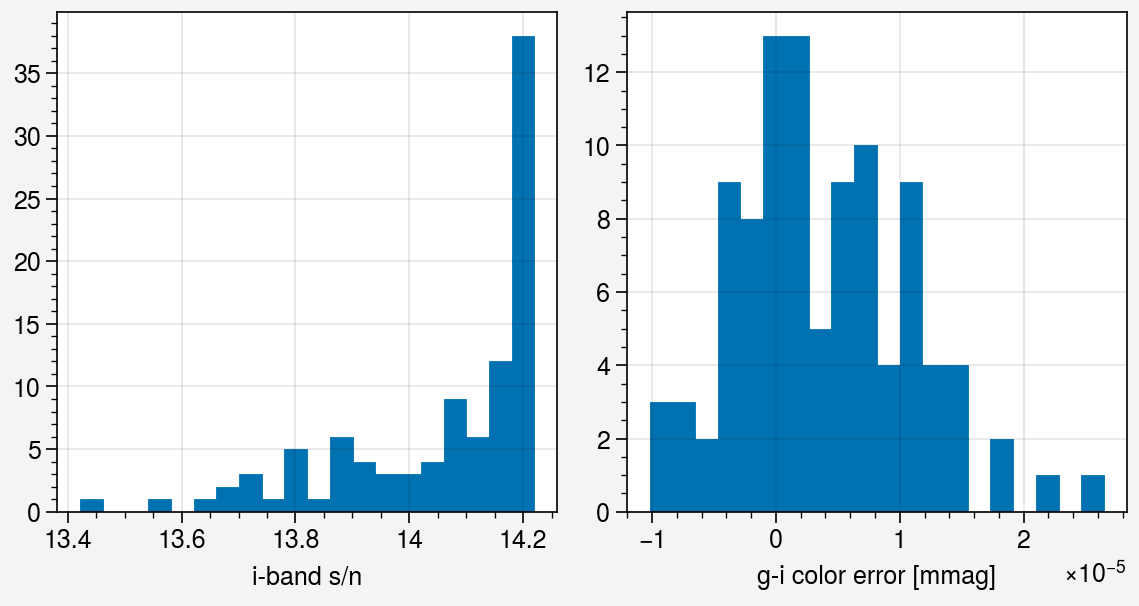

In [55]:
fig, axs = pplt.subplots(ncols=2, share=0)

axs[0].hist(data["s2n_i_obs"], bins=20)
axs[0].format(xlabel="i-band s/n")
axs[1].hist((data["gmi_obs"] - data["gmi_true"]) * 1000, bins=20)
axs[1].format(xlabel="g-i color error [mmag]")

## Now Try Piff

In [57]:
import os
import yaml

pth_i = os.path.expandvars("${MEDS_DIR}/des-pizza-slices-y6-v14/pizza_cutter_info/DES0154-3957_i_pizza_cutter_info.yaml")
pth_g = os.path.expandvars("${MEDS_DIR}/des-pizza-slices-y6-v14/pizza_cutter_info/DES0154-3957_g_pizza_cutter_info.yaml")

with open(pth_i, "r") as fp:
    info_i = yaml.safe_load(fp)

with open(pth_g, "r") as fp:
    info_g = yaml.safe_load(fp)

In [64]:
piff_i = piff.PSF.read(info_i["src_info"][0]["piff_path"])
piff_g = piff.PSF.read(info_g["src_info"][0]["piff_path"])

In [125]:
import tqdm

factor = 1e3

noise = 1e2

buff = 48

num = 100

seeds = np.random.RandomState(seed=42).randint(1, 2**30, size=num)

data = np.zeros(num, dtype=[
    ('gmi_true', 'f8'),
    ('i_true', 'f8'),
    ('s2n_i_obs', 'f8'),
    ('gmi_obs', 'f8'),
    ('i_obs', 'f8'),
])

for i, seed in tqdm.tqdm(
    enumerate(seeds),
    ncols=80,
    total=num,
):
    rng = np.random.RandomState(seed=seed)
    x = rng.uniform(buff, 2048-buff)
    y = rng.uniform(buff, 4096-buff)

    flux_i = 10**((2.5 * np.log10(4) + rng.normal(scale=1)) / 2.5)
    flux_i = flux_i * factor
    flux_g = 1.5 * factor
    mag_i = get_mag(flux_i)
    mag_g = get_mag(flux_g)
    gmi = mag_g - mag_i

    gal = galsim.Sersic(n=2.5, half_light_radius=1.0)
    psf_i = piff_i.get_profile(x, y, GI_COLOR=gmi)[0]
    psf_g = piff_g.get_profile(x, y, GI_COLOR=gmi)[0]
    meas_psf_i = piff_i.get_profile(x, y, GI_COLOR=1.1)[0]
    meas_psf_g = piff_g.get_profile(x, y, GI_COLOR=1.1)[0]

    obs_i = _render_to_ngmix(
        gal=gal.withFlux(flux=flux_i),
        psf=psf_i,
        meas_psf=meas_psf_i,
        rng=np.random.RandomState(seed),
        noise=noise,
        method="no_pixel",
    )
    obs_g = _render_to_ngmix(
        gal=gal.withFlux(flux=flux_g),
        psf=psf_g,
        meas_psf=meas_psf_g,
        rng=np.random.RandomState(seed),
        noise=noise,
        method="no_pixel",
    )

    res = _measure_color(obs_g, obs_i)

    data["gmi_true"][i] = mag_g - mag_i
    data["i_true"][i] = mag_i
    data["s2n_i_obs"][i] = res[2]
    data["gmi_obs"][i] = res[0]
    data["i_obs"][i] = res[1]

dgmi = data["gmi_obs"] - data["gmi_true"]
print("mn: %f\nsd: %f\nrange: %f" % (np.mean(dgmi), np.std(dgmi), np.ptp(dgmi)))


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.56it/s]

mn: -0.002762
sd: 0.019838
range: 0.129639


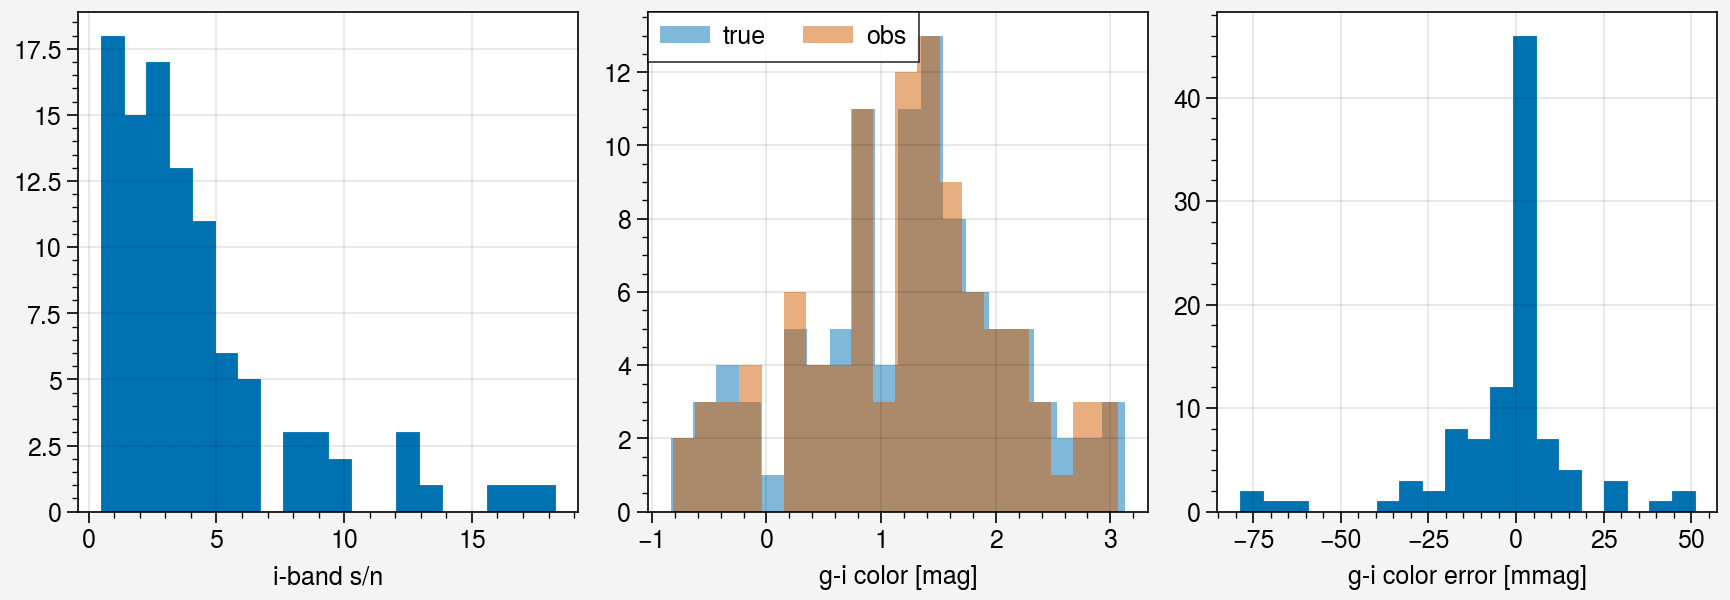

In [126]:
fig, axs = pplt.subplots(ncols=3, share=0)

axs[0].hist(data["s2n_i_obs"], bins=20)
axs[0].format(xlabel="i-band s/n")
axs[1].hist(data["gmi_true"], bins=20, label="true", alpha=0.5)
axs[1].hist(data["gmi_obs"], bins=20, label="obs", alpha=0.5)
axs[1].legend()
axs[1].format(xlabel="g-i color [mag]")
axs[2].hist((data["gmi_obs"] - data["gmi_true"]) * 1000, bins=20)
axs[2].format(xlabel="g-i color error [mmag]")